### Load

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%pylab
%matplotlib inline

Using matplotlib backend: <object object>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from anndata import AnnData
from scipy.sparse import diags
from scipy.io import mmwrite
from tqdm import tqdm
from pathlib import Path
from typing import Union, Optional
import pickle
import seaborn as sns

In [ ]:
from scipy import sparse
from scipy.optimize import fsolve,minimize

In [ ]:
from scDenorm.denorm import *

In [ ]:
def solve_bc(p,y1,y2):
    return sum((np.exp(y2*np.log(p[0]))-2*np.exp(y1*np.log(p[0]))+p[1])**2)

In [ ]:
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
def RCplot1(smtx,xl='Rank of count frequency',yl='Value',xm=None,ym=None,alpha=1,save=None):
    fig, ax = plt.subplots()
    for c_idx in range(smtx.shape[0]):
        c = pd.Series(smtx.getrow(c_idx).data)
        c=c.value_counts().sort_index()
        y = np.array(c.index)
        x = np.arange(0, c.shape[0])+1
        ax.scatter(x, y,alpha=alpha,label=f'Cell {c_idx+1}')


    ax.legend(fontsize=15,frameon=False)#,bbox_to_anchor=(1.05, 1), loc='upper left',frameon=False)
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.set_xlabel(xl,fontsize=18)
    ax.set_ylabel(yl,fontsize=18)
    if ym:
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
        ax.set_ylim(0, ym)
    if xm:
        ax.set_xlim(0, xm)
    if save:
        plt.savefig(save,dpi=300, bbox_inches='tight',transparent=True)

### Mean and variance (add NB fitted curve !!!)

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

def fit_nb(ms):
    
    def nb_func(x, phi):
        return x[0] + (phi * x[0] ** 2)
    
    popt, _ = curve_fit(nb_func, ms['mean'], ms['var'], p0=[1])
    phi = popt[0]
    
    ms['zeros_p'] = np.exp(-ms['mean'])
    ms['zeros_nb'] = (1 + phi * ms['mean']) ** (-1 / phi)
    ms['newVar'] = ms['mean'] + phi * ms['mean'] ** 2
    return ms

In [ ]:
def plot_mv(cmean,cvar,c='blue',fit=False,save=None):
    fig, ax = plt.subplots()
    ax.loglog()
    ax.scatter(cmean, cvar,s=20,c=c)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    ax.plot(lims, lims, linestyle='--', linewidth=2, alpha=0.75, zorder=0,color='black', label='line')
    ax.set_aspect('equal')
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel('Mean',fontsize=18)
    ax.set_ylabel('Variance',fontsize=18)
    
    if fit:
        ms=pd.DataFrame({'mean':cmean[0],'var':cvar[0]})
        ms=fit_nb(ms)
        ms=ms.sort_values('mean')
        plt.plot(ms['mean'],ms['newVar'],'k-', alpha=1, zorder=ms.shape[0],color='red', label='line')
    if save:
        plt.savefig(save,dpi=300, bbox_inches='tight',transparent=True)

## 10 testing dataset with count matrix

In [ ]:
h5_benchmark=['/home/huang_ziliang/project/brain/data/public/human_brain_organoids_Fiorenzano_2021_10x/h5/human_brain_organoids_Fiorenzano_2021_10x.h5ad',
 '/home/huang_ziliang/project/brain/data/public/human_mouse_brain_Welch_2019_10x/h5/GSE126836_SN_MD5534.h5ad',
 '/home/huang_ziliang/project/brain/data/public/mouse_brain_HPF_PFC_Joglekar_2021_10x_PacBio_Visium/h5/mouse_brain_HPF_PFC_Joglekar_2021_10x.h5ad',
 '/home/huang_ziliang/project/brain/data/public/mouse_brain_OB_Mizrak_2020_SCOPE-seq/h5/mouse_brain_OB_Mizrak_2020_SCOPE-seq.h5ad',
 '/home/huang_ziliang/project/brain/data/public/mouse_brain_lateral_hypothalamic_area_Mickelsen_2019_10x/h5/mouse_brain_lateral_hypothalamic_area_Mickelsen_2019_10x.h5ad',
 '/home/huang_ziliang/project/brain/data/public/mouse_brain_choroid_plexus_Dani_2021_10x/h5/mouse_brain_choroid_plexus_Dani_2021_10x.h5ad',
 '/home/huang_ziliang/project/brain/data/public/human_brain_entorhinalcortex_Grubman_2019_DroNc-seq/h5/human_brain_entorhinalcortex_Grubman_2019_DroNc-seq.h5ad',
 '/home/huang_ziliang/project/brain/data/public/mouse_brain_developing_ZhangX_2022_10x/h5/Brain-Young-scRNAseq-rep1.h5ad',
 '/home/huang_ziliang/project/brain/data/public/human_mouse_brain_Chen_2019_SNARE-seq/h5/RNA.h5ad',
 '/home/huang_ziliang/project/brain/data/public/mouse_brain_Hippocampal_Mirabella_2021_10x/h5/mouse_brain_Hippocampal_Mirabella_2021_10x_in_vivo.h5ad']

In [ ]:
bh_ads=[]
for i in h5_benchmark:
    ad=sc.read(i) 
    bh_ads.append(ad[:1000].copy())

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


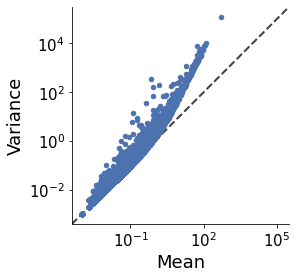

In [ ]:
#figsize(5,5)
smtx=bh_ads[0].X.copy()
cmean = np.array(smtx.mean(0))
cvar = np.array(smtx.power(2).mean(0) - cmean ** 2)
#A
plot_mv(cmean,cvar,c='#4C72B0')#,fit=True,save='figures/pbmc_mvsv_raw_count.pdf')

# Benchmark

## 1.Total count, Different base and pseudo count (1X2, 1X3, 2X3)

In [ ]:
cond=[
[1e3,np.e,1],
[1e4,np.e,1],
[1e5,np.e,1],
[1e6,np.e,1],
[1e4,2,1],
[1e4,10,1],
[1e4,np.e,0.01],
[1e4,np.e,0.1],
]

In [ ]:
smtx2=ad.X
np.random.seed(0)
ys=[]
for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],100),replace=False):
    try:
        c = pd.Series(smtx2.getrow(c_idx).data)
        y = np.array(c.value_counts().sort_index().head(2).index)
        ys.append(y)
    except:
        print(c_idx)
ys=np.array(ys)
y1=ys[:,0]
y2=ys[:,1]
res = minimize(solve_bc, [20,1], method='L-BFGS-B', tol=1e-10,bounds=[(1.9, None), (1e-6, None)],args=(ys[:,0],ys[:,1]))
print(ts,b,c,res.x,res.fun)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1.1075406917685907e-05
        x: [ 1.000e+01  1.000e+00]
      nit: 30
      jac: [ 1.919e-06  1.587e-08]
     nfev: 93
     njev: 31
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


1000.0 2.718281828459045 1 [2.7182816  0.99999999] 8.744798953633387e-13


100%|██████████| 1000/1000 [00:08<00:00, 118.68it/s]


10000.0 2.718281828459045 1 [2.71828184 1.00000001] 2.2704055115304697e-11


100%|██████████| 1000/1000 [00:08<00:00, 118.71it/s]


100000.0 2.718281828459045 1 [2.71828195 0.99999964] 2.5036742195292993e-08


100%|██████████| 1000/1000 [00:08<00:00, 119.15it/s]


1000000.0 2.718281828459045 1 [2.71828226 0.99998405] 1.695381754028032e-06


100%|██████████| 1000/1000 [00:08<00:00, 118.67it/s]


10000.0 2 1 [1.99999993 1.00000004] 5.5694370763021653e-11


100%|██████████| 1000/1000 [00:08<00:00, 119.09it/s]


10000.0 10 1 [10.00000132  0.99999997] 5.333747949484397e-11


100%|██████████| 1000/1000 [00:08<00:00, 119.23it/s]


10000.0 2.718281828459045 0.01 [2.71828233 0.00999964] 3.6927538384161413e-11


100%|██████████| 1000/1000 [00:08<00:00, 118.66it/s]


10000.0 2.718281828459045 0.1 [2.71828192 0.09999996] 1.1562555302063263e-10


100%|██████████| 1000/1000 [00:08<00:00, 119.01it/s]


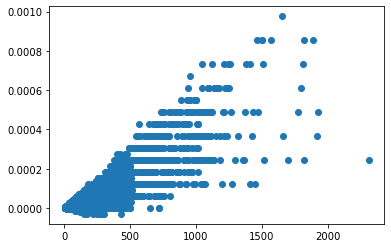

{'bodies': [<matplotlib.collections.PolyCollection>,
  <matplotlib.collections.PolyCollection>,
  <matplotlib.collections.PolyCollection>,
  <matplotlib.collections.PolyCollection>,
  <matplotlib.collections.PolyCollection>,
  <matplotlib.collections.PolyCollection>,
  <matplotlib.collections.PolyCollection>,
  <matplotlib.collections.PolyCollection>],
 'cmaxes': <matplotlib.collections.LineCollection>,
 'cmins': <matplotlib.collections.LineCollection>,
 'cbars': <matplotlib.collections.LineCollection>}

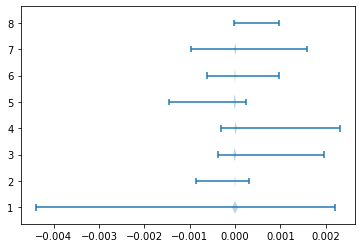

In [ ]:
rs,new_ads=[],[]
for ts,b,c in cond:
    ad=bh_ads[0].copy()
    ad.X=sparse.csc_matrix(ad.X)
    ad.layers['count']=ad.X.copy()
    sc.pp.normalize_total(ad, target_sum=ts)
    ad.X.data=np.log(ad.X.data+c) / np.log(b)
    #sc.pp.log1p(ad,base=b)
    #auto solve
    smtx2=ad.X
    np.random.seed(0)
    ys=[]
    for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],100),replace=False):
        try:
            r = pd.Series(smtx2.getrow(c_idx).data)
            y = np.array(r.value_counts().sort_index().head(2).index)
            ys.append(y)
        except:
            print(c_idx)
    ys=np.array(ys)
    y1=ys[:,0]
    y2=ys[:,1]
    res = minimize(solve_bc, [20,1], method='L-BFGS-B', tol=1e-10,bounds=[(1.9, None), (1e-6, None)],args=(ys[:,0],ys[:,1]))
    print(ts,b,c,res.x,res.fun)
    b,c=res.x
    new_ad=scdenorm(ad,base=b,cont=c,cutoff=0.5,rint=False)
    new_ad.X=sparse.csc_matrix(new_ad.X)
    if np.array_equal(ad.X.indices, new_ad.X.indices) and np.array_equal(ad.X.indptr, new_ad.X.indptr):
        res=new_ad.X.data-new_ad.layers['count'].data
    else:
        raise('index not match')
    rs.append(res)
    new_ads.append(new_ad.copy())
plt.plot(new_ad.layers['count'].data,res,'o')
plt.show()
plt.violinplot(rs,vert=False)

## floating + known base

100%|██████████| 1000/1000 [00:08<00:00, 119.20it/s]


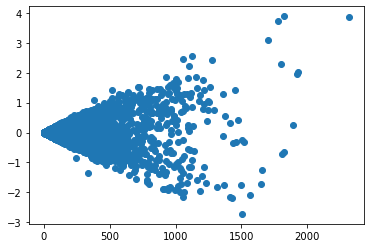

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

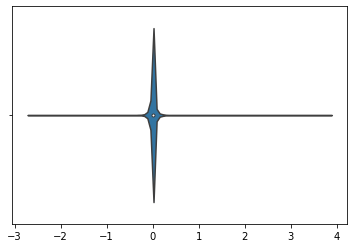

In [ ]:
for ts,b,c in [[1e4,np.e,1]]:
    ad=bh_ads[0].copy()
    ad.X=sparse.csc_matrix(ad.X)
    ad.layers['count']=ad.X.copy()
    sc.pp.normalize_total(ad, target_sum=ts)
    ad.X.data=np.log(ad.X.data+c) / np.log(b)
    #sc.pp.log1p(ad,base=b)
    ad.X.data=ad.X.data.astype(np.float16).astype(np.float32)
    
    new_ad=scdenorm(ad,base=b,cont=c,cutoff=0.5,rint=False)
    new_ad.X=sparse.csc_matrix(new_ad.X)
    if np.array_equal(ad.X.indices, new_ad.X.indices) and np.array_equal(ad.X.indptr, new_ad.X.indptr):
        res=new_ad.X.data-new_ad.layers['count'].data
    else:
        raise('index not match')
        
plt.plot(new_ad.layers['count'].data,res,'o')
plt.show()
sns.violinplot(res)

In [ ]:
fk_res,fk_ad=res,new_ad

## floating + auto base

10000.0 2.718281828459045 1 [2.72018164 0.99939464] 0.0020658411219516824


100%|██████████| 1000/1000 [00:08<00:00, 118.82it/s]


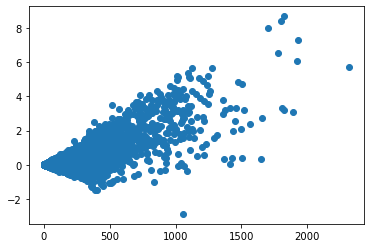

{'bodies': [<matplotlib.collections.PolyCollection>],
 'cmaxes': <matplotlib.collections.LineCollection>,
 'cmins': <matplotlib.collections.LineCollection>,
 'cbars': <matplotlib.collections.LineCollection>}

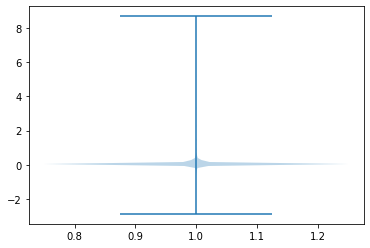

In [ ]:
for ts,b,c in [[1e4,np.e,1]]:
    ad=bh_ads[0].copy()
    ad.X=sparse.csc_matrix(ad.X)
    ad.layers['count']=ad.X.copy()
    sc.pp.normalize_total(ad, target_sum=ts)
    ad.X.data=np.log(ad.X.data+c) / np.log(b)
    #sc.pp.log1p(ad,base=b)
    ad.X.data=ad.X.data.astype(np.float16).astype(np.float32)
    #auto solve
    smtx2=ad.X
    np.random.seed(0)
    ys=[]
    for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],100),replace=False):
        try:
            r = pd.Series(smtx2.getrow(c_idx).data)
            y = np.array(r.value_counts().sort_index().head(2).index)
            ys.append(y)
        except:
            print(c_idx)
    ys=np.array(ys)
    y1=ys[:,0]
    y2=ys[:,1]
    res = minimize(solve_bc, [20,1], method='L-BFGS-B', tol=1e-10,bounds=[(1.9, None), (1e-6, None)],args=(ys[:,0],ys[:,1]))
    print(ts,b,c,res.x,res.fun)
    b,c=res.x
    new_ad=scdenorm(ad,base=b,cont=c,cutoff=0.5,rint=False)
    new_ad.X=sparse.csc_matrix(new_ad.X)
    if np.array_equal(ad.X.indices, new_ad.X.indices) and np.array_equal(ad.X.indptr, new_ad.X.indptr):
        res=new_ad.X.data-new_ad.layers['count'].data
    else:
        raise('index not match')
        
plt.plot(new_ad.layers['count'].data,res,'o')
plt.show()
plt.violinplot(res,vert=True)

In [ ]:
fa_res,fa_ad=res,new_ad.copy()

## HVG + auto base

10000.0 2.718281828459045 1 [2.72018164 0.99939464] 0.0020658411219516824


100%|██████████| 1000/1000 [00:08<00:00, 118.82it/s]


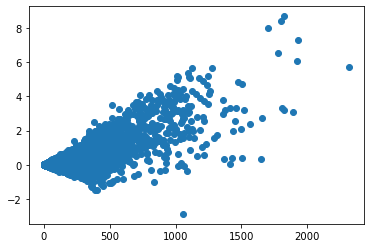

{'bodies': [<matplotlib.collections.PolyCollection>],
 'cmaxes': <matplotlib.collections.LineCollection>,
 'cmins': <matplotlib.collections.LineCollection>,
 'cbars': <matplotlib.collections.LineCollection>}

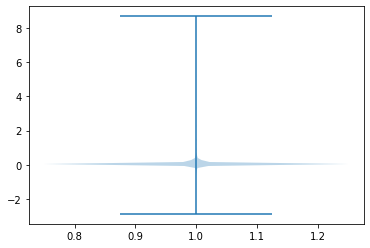

In [ ]:
for ts,b,c in [[1e4,np.e,1]]:
    ad=bh_ads[0].copy()
    ad.X=sparse.csc_matrix(ad.X)
    ad.layers['count']=ad.X.copy()
    sc.pp.normalize_total(ad, target_sum=ts)
    ad.X.data=np.log(ad.X.data+c) / np.log(b)
    #sc.pp.log1p(ad,base=b)
    ad.X.data=ad.X.data.astype(np.float16).astype(np.float32)
    #auto solve
    smtx2=ad.X
    np.random.seed(0)
    ys=[]
    for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],100),replace=False):
        try:
            r = pd.Series(smtx2.getrow(c_idx).data)
            y = np.array(r.value_counts().sort_index().head(2).index)
            ys.append(y)
        except:
            print(c_idx)
    ys=np.array(ys)
    y1=ys[:,0]
    y2=ys[:,1]
    res = minimize(solve_bc, [20,1], method='L-BFGS-B', tol=1e-10,bounds=[(1.9, None), (1e-6, None)],args=(ys[:,0],ys[:,1]))
    print(ts,b,c,res.x,res.fun)
    b,c=res.x
    new_ad=scdenorm(ad,base=b,cont=c,cutoff=0.5,rint=False)
    new_ad.X=sparse.csc_matrix(new_ad.X)
    if np.array_equal(ad.X.indices, new_ad.X.indices) and np.array_equal(ad.X.indptr, new_ad.X.indptr):
        res=new_ad.X.data-new_ad.layers['count'].data
    else:
        raise('index not match')
        
plt.plot(new_ad.layers['count'].data,res,'o')
plt.show()
plt.violinplot(res,vert=True)

100%|██████████| 1000/1000 [00:05<00:00, 172.63it/s]


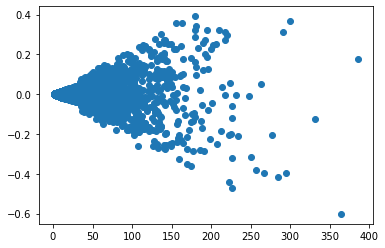

100%|██████████| 1000/1000 [00:05<00:00, 173.22it/s]


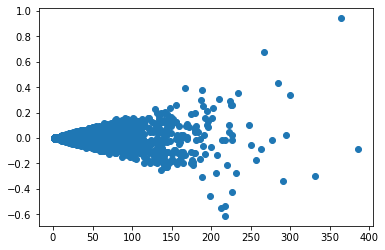

100%|██████████| 1000/1000 [00:05<00:00, 173.95it/s]


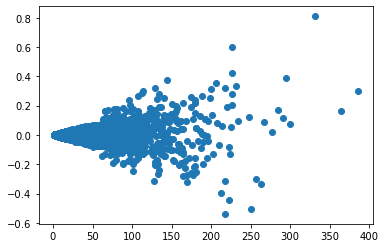

100%|██████████| 1000/1000 [00:05<00:00, 174.94it/s]


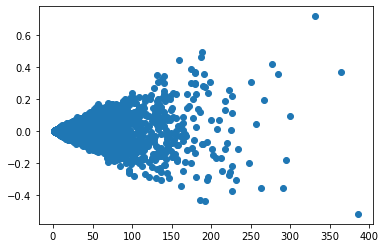

100%|██████████| 1000/1000 [00:05<00:00, 175.74it/s]


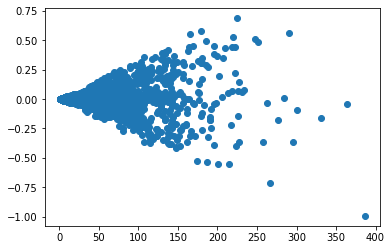

100%|██████████| 1000/1000 [00:05<00:00, 175.20it/s]


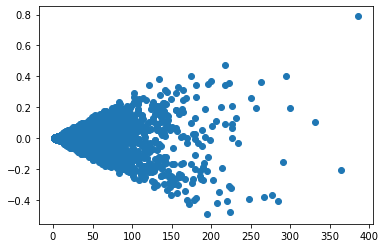

100%|██████████| 1000/1000 [00:05<00:00, 176.84it/s]


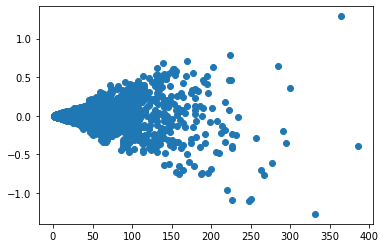

100%|██████████| 1000/1000 [00:05<00:00, 175.86it/s]


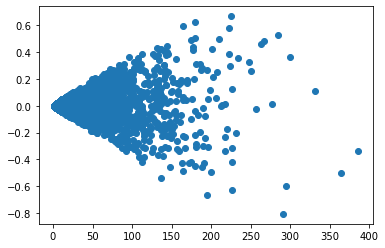

100%|██████████| 1000/1000 [00:05<00:00, 176.42it/s]


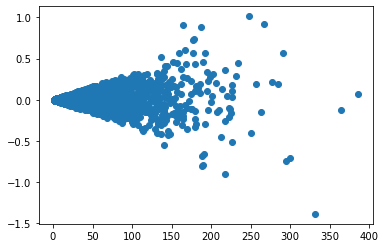

100%|██████████| 1000/1000 [00:05<00:00, 176.92it/s]


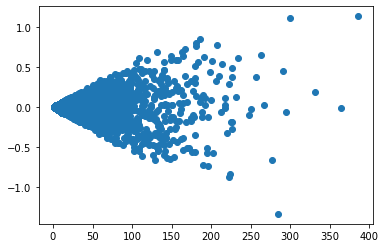

100%|██████████| 1000/1000 [00:05<00:00, 175.64it/s]


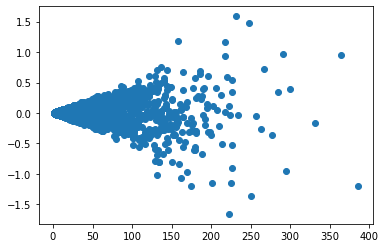

100%|██████████| 1000/1000 [00:05<00:00, 176.61it/s]


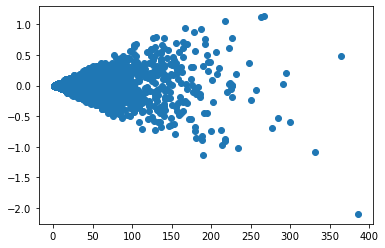

{'bodies': [<matplotlib.collections.PolyCollection>,
  <matplotlib.collections.PolyCollection>,
  <matplotlib.collections.PolyCollection>,
  <matplotlib.collections.PolyCollection>,
  <matplotlib.collections.PolyCollection>,
  <matplotlib.collections.PolyCollection>,
  <matplotlib.collections.PolyCollection>,
  <matplotlib.collections.PolyCollection>,
  <matplotlib.collections.PolyCollection>,
  <matplotlib.collections.PolyCollection>,
  <matplotlib.collections.PolyCollection>,
  <matplotlib.collections.PolyCollection>],
 'cmaxes': <matplotlib.collections.LineCollection>,
 'cmins': <matplotlib.collections.LineCollection>,
 'cbars': <matplotlib.collections.LineCollection>}

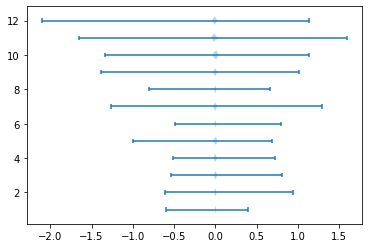

In [ ]:
rs=[]
for ts in [2e3,1e4,1e5,1e6]:
    for b in [np.e,2,10]:
        ad=bh_ads[1].copy()
        ad.X=sparse.csc_matrix(ad.X)
        ad.layers['count']=ad.X.copy()
        sc.pp.normalize_total(ad, target_sum=ts)
        #ad.X.data=np.log(ad.X.data+1) / np.log(b)
        sc.pp.log1p(ad,base=b)
        ad.X.data=ad.X.data.astype(np.float16).astype(np.float32)
        new_ad=scdenorm(ad,base=b,cutoff=0.5,rint=False)
        new_ad.X=sparse.csc_matrix(new_ad.X)
        if np.array_equal(ad.X.indices, new_ad.X.indices) and np.array_equal(ad.X.indptr, new_ad.X.indptr):
            res=new_ad.X.data-new_ad.layers['count'].data
            plt.plot(new_ad.layers['count'].data,res,'o')
            plt.show()
        else:
            raise('index not match')
        rs.append(res)
plt.violinplot(rs,vert=False)

[<matplotlib.lines.Line2D>]

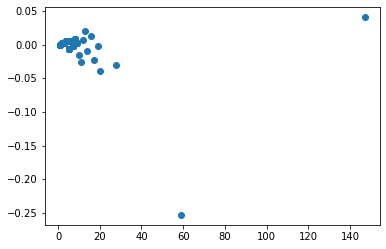

In [ ]:
plt.plot(new_ad.layers['count'].data,rs[-1],'o')

In [ ]:
rs

[array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([2., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([-2.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([5., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([-3.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([7., 1., 0., ..., 0., 1., 0.], dtype=float32),
 array([-4., -1.,  0., ...,  0., -1.,  0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([7., 1., 0., ..., 0., 1., 0.], dtype=float32),
 array([-4., -1.,  0., ...,  0., -1.,  0.], dtype=float32)]

In [ ]:
rs[-1]

array([-4., -1.,  0., ..., -1., -1.,  0.], dtype=float32)

In [ ]:
new_ad[:1].X.data

array([2., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [ ]:
new_ad[:1].layers['count'].data

array([6., 2., 1., ..., 1., 2., 1.], dtype=float32)

In [ ]:
ad[:1].X.data

array([3.2597656, 2.7832031, 2.4824219, ..., 2.4824219, 2.7832031,
       2.4824219], dtype=float32)

In [ ]:
ad[:1].layers['count'].data

array([6., 2., 1., ..., 1., 2., 1.], dtype=float32)

In [ ]:
10**ad[:1].X.data-1

array([1817.7191 ,  606.02014,  302.68396, ...,  302.68396,  606.02014,
        302.68396], dtype=float32)

In [ ]:
print(ad[:1].X)

  (0, 3)	3.2597656
  (0, 6)	2.7832031
  (0, 20)	2.4824219
  (0, 21)	2.7832031
  (0, 26)	2.4824219
  (0, 52)	2.4824219
  (0, 64)	2.4824219
  (0, 70)	2.7832031
  (0, 77)	2.4824219
  (0, 92)	2.4824219
  (0, 99)	2.4824219
  (0, 105)	2.7832031
  (0, 109)	2.7832031
  (0, 112)	2.4824219
  (0, 113)	2.4824219
  (0, 116)	2.4824219
  (0, 117)	2.4824219
  (0, 122)	2.7832031
  (0, 273)	2.4824219
  (0, 316)	2.4824219
  (0, 346)	2.4824219
  (0, 438)	2.4824219
  (0, 490)	2.4824219
  (0, 616)	2.4824219
  (0, 644)	2.4824219
  :	:
  (0, 29110)	2.4824219
  (0, 29115)	2.4824219
  (0, 29123)	2.4824219
  (0, 29127)	2.4824219
  (0, 29174)	2.4824219
  (0, 29190)	2.7832031
  (0, 29197)	2.4824219
  (0, 29211)	2.4824219
  (0, 29214)	2.4824219
  (0, 29219)	2.4824219
  (0, 29223)	2.4824219
  (0, 29269)	2.4824219
  (0, 29276)	2.4824219
  (0, 29325)	2.4824219
  (0, 29342)	2.7832031
  (0, 29345)	2.4824219
  (0, 29352)	2.4824219
  (0, 29374)	2.4824219
  (0, 29382)	2.7832031
  (0, 29397)	2.4824219
  (0, 29426)	2.4824219

In [ ]:
print(new_ad[:1].X)

  (0, 3)	2.0
  (0, 6)	1.0
  (0, 20)	1.0
  (0, 21)	1.0
  (0, 26)	1.0
  (0, 52)	1.0
  (0, 64)	1.0
  (0, 70)	1.0
  (0, 77)	1.0
  (0, 92)	1.0
  (0, 99)	1.0
  (0, 105)	1.0
  (0, 109)	1.0
  (0, 112)	1.0
  (0, 113)	1.0
  (0, 116)	1.0
  (0, 117)	1.0
  (0, 122)	1.0
  (0, 273)	1.0
  (0, 316)	1.0
  (0, 346)	1.0
  (0, 438)	1.0
  (0, 490)	1.0
  (0, 616)	1.0
  (0, 644)	1.0
  :	:
  (0, 29110)	1.0
  (0, 29115)	1.0
  (0, 29123)	1.0
  (0, 29127)	1.0
  (0, 29174)	1.0
  (0, 29190)	1.0
  (0, 29197)	1.0
  (0, 29211)	1.0
  (0, 29214)	1.0
  (0, 29219)	1.0
  (0, 29223)	1.0
  (0, 29269)	1.0
  (0, 29276)	1.0
  (0, 29325)	1.0
  (0, 29342)	1.0
  (0, 29345)	1.0
  (0, 29352)	1.0
  (0, 29374)	1.0
  (0, 29382)	1.0
  (0, 29397)	1.0
  (0, 29426)	1.0
  (0, 29427)	2.0
  (0, 29428)	1.0
  (0, 29440)	1.0
  (0, 29441)	1.0


In [ ]:
(pd.Series(10**ad[:1].X.data-1)/302.683960).value_counts()

1.000000      1528
2.002155       350
3.002738        94
4.005317        41
4.993567        12
6.005337        10
6.998057        10
8.009347         5
9.003225         4
12.007096        1
58.747066        1
18.997686        1
19.961296        1
147.040970       1
13.019776        1
9.984715         1
27.970078        1
16.977102        1
13.991401        1
10.973983        1
16.012821        1
dtype: int64

In [ ]:
rs[-1]

array([-4., -1.,  0., ..., -1., -1.,  0.], dtype=float32)

{'whiskers': [<matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>],
 'caps': [<matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>,
  <matplotlib.lines.Li

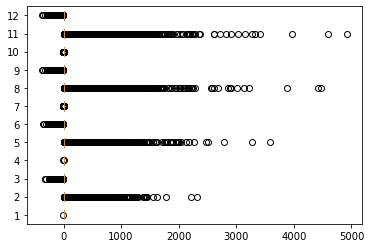

In [ ]:
plt.boxplot(rs,vert=False)

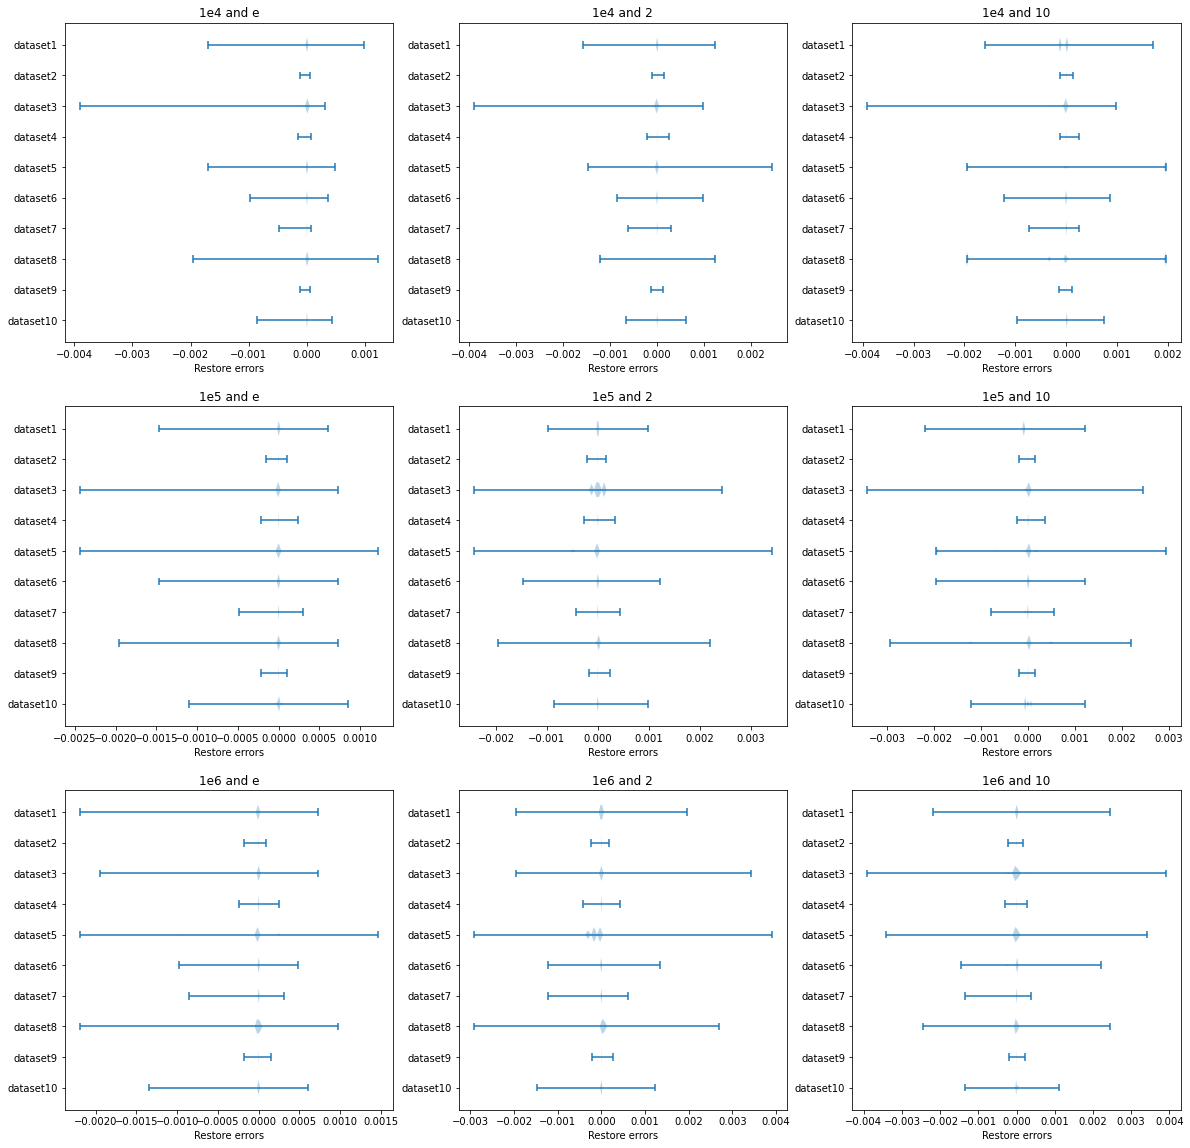

In [ ]:
fig, axs = plt.subplots(3,3,figsize=(20,20))
axs = axs.ravel()
for i,ress in enumerate(rs):
    ax=axs[i]
    ax.violinplot(ress.values(),vert=False)
    ax.set_yticks([i+1 for i in range(10)])
    ax.set_yticklabels(['dataset'+str(10-i) for i in range(10)])
    ax.set_xlabel("Restore errors")
    ax.title.set_text(titles[i])
plt.savefig('figures/Sup_figure_3.pdf',dpi=600,format='pdf', transparent=True)
plt.show()

In [ ]:
rs

[array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)]

In [ ]:
import pickle
with open('data/restore_errors_all.pickle', 'wb') as handle:
    pickle.dump(rs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('data/restore_errors_all.pickle', 'rb') as handle:
    rs = pickle.load(handle)

In [ ]:
titles=[]
for ts in ['1e4','1e5','1e6']:
    for b in ['e','2','10']:
        titles.append(f'{ts} and {b}')

In [ ]:
titles

['1e4 and e',
 '1e4 and 2',
 '1e4 and 10',
 '1e5 and e',
 '1e5 and 2',
 '1e5 and 10',
 '1e6 and e',
 '1e6 and 2',
 '1e6 and 10']

In [ ]:
Total count, Different base and pseudo count (1X2, 1X3, 2X3) 
Filtering genes
Floating errors
- Speed cell and genes


# End Benchmark

In [ ]:
df = sc.read_mtx('data/GSE173278_scRNAseq_filtered_cells_norm_counts_matrix.mtx.gz')

In [ ]:
df=df.T

In [ ]:
adata=sc.AnnData(df)

/tmp/ipykernel_522/2203572198.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata=sc.AnnData(df)


In [ ]:
adata.X=sparse.csr_matrix(adata.X)

In [ ]:
adata.obs_names = df.index
adata.var_names = df.columns

In [ ]:
adata.X.data

array([0.7879559, 0.7879559, 1.2231264, ..., 2.9033496, 1.0346863,
       2.4753058], dtype=float32)

In [ ]:
adata.write_h5ad('data/GSE173278_scRNAseq_filtered_cells_norm_counts_matrix.h5ad')

In [ ]:
df = pd.read_csv('data/GSE114374_Human_HC_expression_matrix.txt.gz', sep='\t', compression='gzip', index_col=0)

In [ ]:
df=df.T

In [ ]:
adata=sc.AnnData(df)

In [ ]:
adata.X.data

array([1.7404792, 1.7404792, 1.7404792, ..., 6.193616 , 2.712208 ,
       5.890179 ], dtype=float32)

In [ ]:
adata.write_h5ad('data/GSE114374_Human_HC_expression_matrix.h5ad')

In [ ]:
adata=sc.read('data/GSE173278_scRNAseq_filtered_cells_norm_counts_matrix.h5ad')

In [ ]:
adata=sc.read('data/GSE114374_Human_HC_expression_matrix.h5ad')

In [ ]:
scdenorm(adata)

ERROR:root:The base 2.718281828459045 is not match with the data.
ERROR:root:The base 1 is not match with the data.
100%|██████████| 75075/75075 [00:46<00:00, 1606.65it/s]


AnnData object with n_obs × n_vars = 75075 × 23076

In [ ]:
smtx1=adata.X.copy()
smtx1.data=2**smtx1.data-1

In [ ]:
smtx1.sum(axis=1)

matrix([[ 9674.918],
        [11520.103],
        [ 9375.332],
        ...,
        [12007.006],
        [11277.199],
        [10199.91 ]], dtype=float32)

##  Sup Figure 5 - denormalizing a normalized expression on three published datasets

In [ ]:
df = sc.read_mtx('data/GSM5717477_MCF7_DMSO_filtered_peak_bc_matrix.mtx.gz')

In [ ]:
df=df.T

In [ ]:
df.X.data

array([2., 2., 2., ..., 2., 2., 2.], dtype=float32)

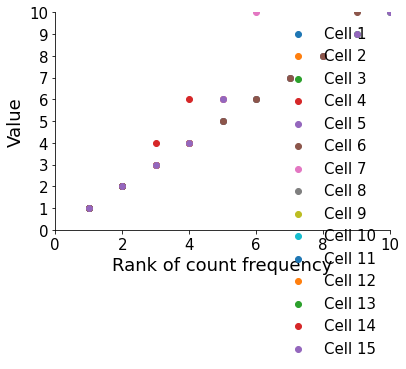

In [ ]:
RCplot1(df.X[:15],xm=10,ym=10)

In [ ]:
matrix

<Closed HDF5 group>

In [ ]:
dataset.v

AttributeError: 'Group' object has no attribute 'var'

In [ ]:
import h5py

# open the h5 file
with h5py.File('/home/huang_ziliang/project/brain/data/public/mouse_brain_Cortex_DiBella_2021_10x_scATAC/GSE153163_RAW/GSM4635091_E18_5_filtered_peak_bc_matrix.h5', "r") as f:

    # print the keys of the file
    print("Keys: %s" % f.keys())
    
    # get the matrix data
    dataset = f["/matrix/data"]
    print(dataset[:10])

Keys: <KeysViewHDF5 ['matrix']>
[1 2 2 2 2 2 2 2 2 2]


In [ ]:
print(dataset)
    #print(dataset.var)
    dataset=dataset["/matrix"]
    print(dataset['barcodes'])
    print(dataset['data'])
    print(dataset['features'])
    print(list(dataset))
    attributes = dataset.attrs
    print(attributes)

    # get a subset of the dataset
    subset = dataset[0:10, 0:10]
    print(subset)

In [ ]:
matrix.attrs

<Attributes of closed HDF5 object>

In [ ]:
dataset.attrs

<Attributes of closed HDF5 object>

In [ ]:
df = pd.DataFrame.sparse.from_spmatrix(dataset)

AttributeError: 'Dataset' object has no attribute 'tocsc'

In [ ]:
matrix.

In [ ]:
ad=sc.read(h5_paths_norm[3])

In [ ]:
ad

AnnData object with n_obs × n_vars = 10032 × 18133
    obs: 'samplename', 'donor_id', 'original_name', 'batch'

In [ ]:
ad.X.data

array([4.7709317, 7.8931046, 4.7709317, ..., 5.512317 , 5.512317 ,
       5.512317 ], dtype=float32)

In [ ]:
h5_paths_norm=[
 '/home/huang_ziliang/project/brain/data/public/mouse_brain_source_Habib_2017/h5/mouse.h5ad',
 '/home/huang_ziliang/project/brain/data/public/human_brain_vascular_winkler_2022_10x/Immune-Arteriovenous_Malformation_Control.h5ad',             
               
'/home/huang_ziliang/project/brain/data/public/mouse_brain_Cortex_DiBella_2021_10x_scATAC/h5/mouse_brain_Cortex_DiBella_2021_10x.h5ad',
'/home/huang_ziliang/project/brain/data/public/human_brain_cerebral_organoids_Fleck_2022_10x_ATAC/CROPseq_srt.h5ad',

'/home/huang_ziliang/project/brain/data/public/mouse_brain_BasalGanglia_Wallace_2017_Drop-seq/h5/mouse_brain_BasalGanglia_Wallace_2017_Drop-seq.h5ad',
#'/home/huang_ziliang/project/brain/data/public/human_mouse_brain_source_Gaublomme_2019/h5/experiment1_all_lowremove.h5ad',
]

In [ ]:
h5_names=[
 'Habib et al NMeth 2017',
 'Winkler et al Science 2022',
 'Di Bella et al Nature 2021',
 'Fleck et al Nature 2022',
 'Wallace et al Neuron 2017',
#'Gaublomme et al Nature 2019',
]

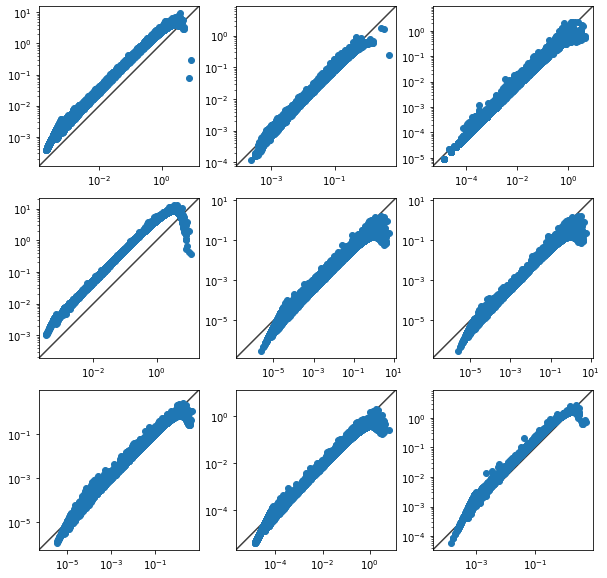

In [ ]:
fig, axs = plt.subplots(3,3,figsize=(10,10))
axs = axs.ravel()
for i,h5 in enumerate(h5_paths_norm):
    ad=sc.read(h5)
    smtx=ad.X
    cmean = np.array(smtx.mean(0))
    cvar = np.array(smtx.power(2).mean(0) - cmean ** 2)

    ax=axs[i]
    ax.loglog()
    ax.scatter(cmean, cvar)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    #ax.title.set_text(h5.split('/')[-3])
#plt.savefig('figures/Sup_figure_1.pdf',dpi=600,format='pdf', transparent=True)
plt.show()

In [ ]:
fig, axs = plt.subplots(3,3,figsize=(10,10))
axs = axs.ravel()
for i,h5 in enumerate(h5_paths_norm):
    ad=sc.read(h5)
    ad=scdenorm(ad,verbose=1)
    smtx=ad.X
    cmean = np.array(smtx.mean(0))
    cvar = np.array(smtx.power(2).mean(0) - cmean ** 2)

    ax=axs[i]
    ax.loglog()
    ax.scatter(cmean, cvar)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
plt.show()

INFO:root:The dimensions of this data are (9923, 28363).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 9923/9923 [00:12<00:00, 823.74it/s]
INFO:root:The dimensions of this data are (13313, 17308).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 13313/13313 [00:07<00:00, 1745.49it/s]
INFO:root:The dimensions of this data are (55255, 39974).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 55255/55255 [00:32<00:00, 1685.79it/s]
INFO:root:The dimensions of this data are (10032, 18133).
INFO:root:select base
ERROR:root:The base 2.718281828459045 is not match with the data.
ERROR:root:The base 1 is not match with the data.
INFO:root:denormlizing ...the base is 2
100%|██████████| 10032/10032 [00:05<00:00, 1736.57it/s]
INFO:root:The dimensions of this data are (49271, 21730).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


In [ ]:
ads=[]
for i in h5_paths_norm:
    ad=sc.read(i) 
    ads.append(ad[:1000].copy())

In [ ]:
total_sum=[]
for ad in ads:
    smtx1=ad.X.copy()
    smtx1.data=np.exp(smtx1.data)-1
    total_sum.append(pd.DataFrame(smtx1.sum(axis=1)))

In [ ]:
total_sum=pd.concat(total_sum)

In [ ]:
total_sum.columns=['total']

In [ ]:
total_sum['name']=[x for x in h5_names for i in range(1000)]

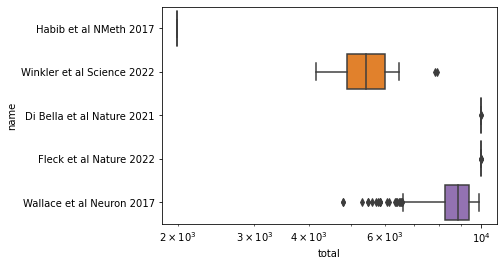

In [ ]:
fig,ax=plt.subplots()
sns.boxplot(data=total_sum,y='name',x='total',ax=ax)
ax.set_xscale("log", base=10)

## rounding errors

In [ ]:
rounding_ers=[]
for ad in ads:
    ad1=scdenorm(ad,verbose=1,cutoff=0.5)
    ad1.X.sort_indices()

    ad2=scdenorm(ad,verbose=1,cutoff=0.5,rint=False)
    ad2.X.sort_indices()

    tmp2=ad1.X.copy()
    tmp2.data=tmp2.data-ad2.X.data
    rounding_ers.append(tmp2.copy())

INFO:root:The dimensions of this data are (1000, 17308).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1680.94it/s]
INFO:root:The dimensions of this data are (1000, 17308).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1708.62it/s]
INFO:root:The dimensions of this data are (1000, 39974).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1572.52it/s]
INFO:root:The dimensions of this data are (1000, 39974).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1655.26it/s]
INFO:root:The dimensions of this data are (1000, 19712).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1668.15it/s]
INFO:root:The dimensions of this data are (1000, 19712)

In [ ]:
rounding_ers1=[]
for i,tmp2 in zip(h5_names,rounding_ers):
    tmp2=pd.DataFrame(tmp2.data)
    tmp2.columns=['error']
    tmp2['name']=i
    rounding_ers1.append(tmp2)

In [ ]:
rounding_ers1=pd.concat(rounding_ers1)

<AxesSubplot:xlabel='error', ylabel='name'>

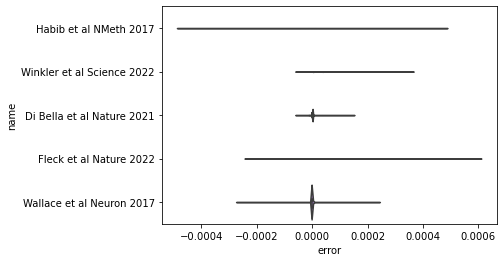

In [ ]:
fig,ax=plt.subplots()
sns.violinplot(data=rounding_ers1,y='name',x='error',inner="quartile",ax=ax)

<AxesSubplot:xlabel='error', ylabel='name'>

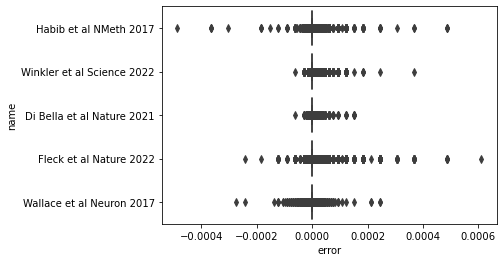

In [ ]:
fig,ax=plt.subplots()
sns.boxplot(data=rounding_ers1,y='name',x='error',ax=ax)

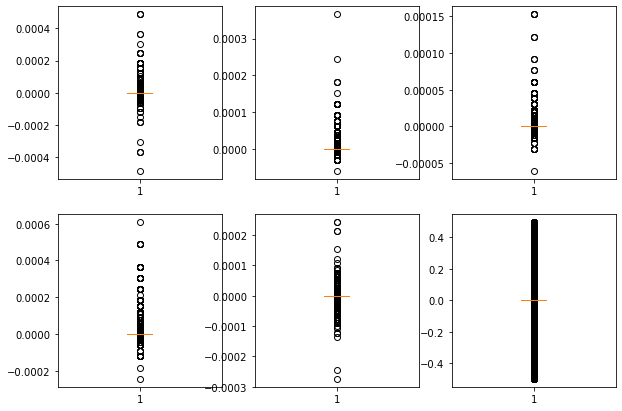

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(10,7))
axs = axs.ravel()
for i,tmp2 in enumerate(rounding_ers):
    ax=axs[i]
    ax.boxplot(tmp2.data)
plt.show()

## reconstruction errros

In [ ]:
ad1=ads[0].copy()
ad1.X.sort_indices()

ad3=scdenorm(ad1,verbose=1,cutoff=0.5)
sc.pp.normalize_total(ad3, target_sum=2000)
sc.pp.log1p(ad3)
ad3.X.sort_indices()

INFO:root:The dimensions of this data are (1000, 17308).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1719.55it/s]


In [ ]:
ad1=ads[0].copy()
ad1.X.sort_indices()

ad3=scdenorm(ad1,verbose=1,cutoff=0.5)
sc.pp.normalize_total(ad3, target_sum=2000)
sc.pp.log1p(ad3)
ad3.X.sort_indices()

INFO:root:The dimensions of this data are (1000, 17308).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1719.54it/s]


[<matplotlib.lines.Line2D>]

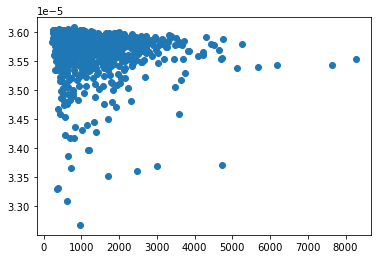

In [ ]:
tmp2=ad3.X.copy()
tmp2=np.power(ad3.X.todense()-ad1.X.todense(),2)
plt.plot(np.array([len(ad3.X.getrow(i).data) for i in range(ad3.shape[0])]),tmp2.max(axis=1),'o')
#recon_ers.append(pd.DataFrame(tmp2.sum(axis=1))[0]/np.array([len(ad3.X.getrow(i).data) for i in range(ad3.shape[0])]))

In [ ]:
ad1=ads[2].copy()
ad1.X.sort_indices()

ad3=scdenorm(ad1,verbose=1,cutoff=0.5)
sc.pp.normalize_total(ad3, target_sum=10000)
sc.pp.log1p(ad3)
ad3.X.sort_indices()

INFO:root:The dimensions of this data are (1000, 19712).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1714.49it/s]


[<matplotlib.lines.Line2D>]

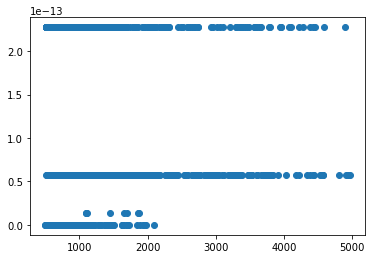

In [ ]:
tmp2=ad3.X.copy()
tmp2=np.power(ad3.X.todense()-ad1.X.todense(),2)
plt.plot(np.array([len(ad3.X.getrow(i).data) for i in range(ad3.shape[0])]),tmp2.max(axis=1),'o')
#recon_ers.append(pd.DataFrame(tmp2.sum(axis=1))[0]/np.array([len(ad3.X.getrow(i).data) for i in range(ad3.shape[0])]))

In [ ]:
ad1=ads[3].copy()
ad1.X.sort_indices()

ad3=scdenorm(ad1,verbose=1,cutoff=0.5)
sc.pp.normalize_total(ad3, target_sum=10000)
sc.pp.log1p(ad3)
ad3.X.sort_indices()

INFO:root:The dimensions of this data are (1000, 45068).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:07<00:00, 129.68it/s]


[<matplotlib.lines.Line2D>]

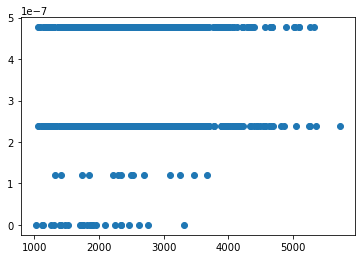

In [ ]:
tmp2=ad3.X.copy()
tmp2=np.abs(ad3.X.todense()-ad1.X.todense())
plt.plot(np.array([len(ad3.X.getrow(i).data) for i in range(ad3.shape[0])]),tmp2.max(axis=1),'o')
#recon_ers.append(pd.DataFrame(tmp2.sum(axis=1))[0]/np.array([len(ad3.X.getrow(i).data) for i in range(ad3.shape[0])]))

In [ ]:
tmp2=ad3.X.copy()
tmp2=np.abs(ad3.X.todense()-ad1.X.todense())
plt.plot(np.array([len(ad3.X.getrow(i).data) for i in range(ad3.shape[0])]),tmp2.max(axis=1),'o')
#recon_ers.append(pd.DataFrame(tmp2.sum(axis=1))[0]/np.array([len(ad3.X.getrow(i).data) for i in range(ad3.shape[0])]))

In [ ]:
recon_ers=[]
for i,t in zip([0,2,3],[2e3,1e4,1e4]):
    ad1=ads[i].copy()
    ad1.X.sort_indices()
    
    ad3=scdenorm(ad1,verbose=1,cutoff=0.5)
    sc.pp.normalize_total(ad3, target_sum=t)
    sc.pp.log1p(ad3)
    ad3.X.sort_indices()

    tmp2=ad3.X.copy()
    tmp2=np.power(ad3.X.todense()-ad1.X.todense(),2)
    recon_ers.append(pd.DataFrame(tmp2.sum(axis=1))[0])#/np.array([len(ad3.X.getrow(i).data) for i in range(ad3.shape[0])]))

INFO:root:The dimensions of this data are (1000, 17308).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1705.48it/s]
INFO:root:The dimensions of this data are (1000, 19712).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1689.84it/s]
INFO:root:The dimensions of this data are (1000, 45068).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:07<00:00, 130.63it/s]


In [ ]:
recon_ers1=[]
for i,t in zip([0,2,3],[2e3,1e4,1e4]):
    ad1=ads[i].copy()
    ad1.X.sort_indices()
    
    ad3=scdenorm(ad1,verbose=1,cutoff=0.5)
    sc.pp.normalize_total(ad3, target_sum=t)
    sc.pp.log1p(ad3)
    ad3.X.sort_indices()

    tmp2=(ad3.X-ad1.X)
    recon_ers1.append(tmp2.sum(axis=1))

INFO:root:The dimensions of this data are (1000, 17308).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1707.05it/s]
INFO:root:The dimensions of this data are (1000, 19712).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1716.47it/s]
INFO:root:The dimensions of this data are (1000, 45068).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:07<00:00, 130.87it/s]


In [ ]:
ad1.X=sparse.csr_matrix(ad1.X)

In [ ]:
print(ad1.X)

  (0, 40)	1.0678526
  (0, 43)	1.0678526
  (0, 53)	1.0678526
  (0, 55)	1.0678526
  (0, 93)	1.0678526
  (0, 99)	1.9061853
  (0, 100)	1.0678526
  (0, 128)	1.0678526
  (0, 154)	2.7895076
  (0, 190)	1.5724111
  (0, 198)	1.0678526
  (0, 201)	1.5724111
  (0, 222)	1.9061853
  (0, 223)	1.0678526
  (0, 244)	1.0678526
  (0, 316)	1.0678526
  (0, 346)	1.0678526
  (0, 390)	1.5724111
  (0, 408)	1.0678526
  (0, 412)	1.5724111
  (0, 445)	1.0678526
  (0, 450)	1.0678526
  (0, 473)	1.0678526
  (0, 483)	1.0678526
  (0, 493)	3.7158046
  :	:
  (999, 33394)	0.6043232
  (999, 33396)	0.9783361
  (999, 33400)	0.6043232
  (999, 33412)	0.6043232
  (999, 33443)	0.6043232
  (999, 33445)	0.9783361
  (999, 33446)	1.6390096
  (999, 33456)	0.6043232
  (999, 33487)	0.6043232
  (999, 33492)	0.6043232
  (999, 33495)	0.6043232
  (999, 33496)	3.4301243
  (999, 33497)	2.5352976
  (999, 33498)	5.0928454
  (999, 33499)	4.973918
  (999, 33500)	1.7884339
  (999, 33501)	4.326794
  (999, 33502)	4.968161
  (999, 33503)	4.0792465
  (

In [ ]:
print(ad3.X)

  (0, 40)	1.0678525
  (0, 43)	1.0678525
  (0, 53)	1.0678525
  (0, 55)	1.0678525
  (0, 93)	1.0678525
  (0, 99)	1.9061853
  (0, 100)	1.0678525
  (0, 128)	1.0678525
  (0, 154)	2.7895076
  (0, 190)	1.5724111
  (0, 198)	1.0678525
  (0, 201)	1.5724111
  (0, 222)	1.9061853
  (0, 223)	1.0678525
  (0, 244)	1.0678525
  (0, 316)	1.0678525
  (0, 346)	1.0678525
  (0, 390)	1.5724111
  (0, 408)	1.0678525
  (0, 412)	1.5724111
  (0, 445)	1.0678525
  (0, 450)	1.0678525
  (0, 473)	1.0678525
  (0, 483)	1.0678525
  (0, 493)	3.7158046
  :	:
  (999, 33394)	0.6043232
  (999, 33396)	0.9783361
  (999, 33400)	0.6043232
  (999, 33412)	0.6043232
  (999, 33443)	0.6043232
  (999, 33445)	0.9783361
  (999, 33446)	1.6390096
  (999, 33456)	0.6043232
  (999, 33487)	0.6043232
  (999, 33492)	0.6043232
  (999, 33495)	0.6043232
  (999, 33496)	3.4301243
  (999, 33497)	2.5352976
  (999, 33498)	5.0928454
  (999, 33499)	4.973918
  (999, 33500)	1.7884339
  (999, 33501)	4.326794
  (999, 33502)	4.968161
  (999, 33503)	4.0792465
  (

In [ ]:
ad1.X.indices

array([158, 787,   1, ..., 992, 993, 964], dtype=int32)

In [ ]:
ad3.X.indices

array([   40,    43,    53, ..., 33507, 33508, 33525], dtype=int32)

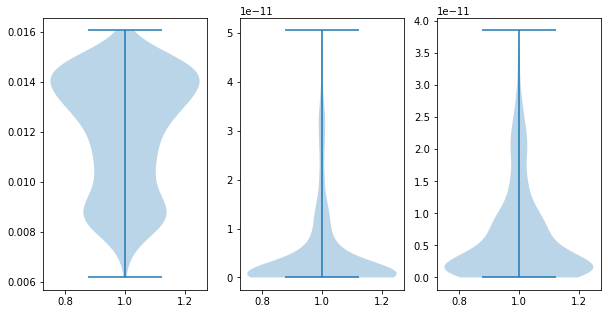

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(10,5))
axs = axs.ravel()
for i,tmp2 in enumerate(recon_ers):
    ax=axs[i]
    ax.violinplot(pd.DataFrame(tmp2)[0])
plt.show()

In [ ]:
ads[-4].X.data

array([0.62097067, 0.62097067, 0.62097067, ..., 1.0191548 , 1.0191548 ,
       1.0191548 ], dtype=float32)

In [ ]:
ad=ads[-5]
ad1=ad.copy()
ad1.X.sort_indices()

ad3=scdenorm(ad,verbose=1,cutoff=0.5)
sc.pp.normalize_total(ad3, target_sum=1e4)
sc.pp.log1p(ad3)
ad3.X.sort_indices()

INFO:root:The dimensions of this data are (1000, 21730).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1623.74it/s]


In [ ]:
sc.pp.normalize_total(ad3, target_sum=1e4)
sc.pp.log1p(ad3)

In [ ]:
ad.layers['counts'].data

array([2., 2., 1., ..., 1., 4., 2.], dtype=float32)

In [ ]:
ad3=scdenorm(ad,verbose=1,cutoff=0.5)

INFO:root:The dimensions of this data are (1000, 21062).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1534.58it/s]


In [ ]:
print(ad3.X)

  (0, 16)	2.0
  (0, 22)	1.0
  (0, 26)	1.0
  (0, 43)	1.0
  (0, 52)	1.0
  (0, 54)	2.0
  (0, 77)	1.0
  (0, 82)	1.0
  (0, 85)	1.0
  (0, 92)	2.0
  (0, 96)	1.0
  (0, 104)	1.0
  (0, 112)	2.0
  (0, 126)	4.0
  (0, 129)	1.0
  (0, 131)	1.0
  (0, 132)	5.0
  (0, 141)	1.0
  (0, 154)	1.0
  (0, 166)	1.0
  (0, 193)	1.0
  (0, 195)	8.0
  (0, 214)	1.0
  (0, 229)	1.0
  (0, 236)	1.0
  :	:
  (999, 20807)	6.0
  (999, 20808)	2.0
  (999, 20810)	1.0
  (999, 20818)	15.0
  (999, 20824)	1.0
  (999, 20827)	3.0
  (999, 20882)	2.0
  (999, 20894)	1.0
  (999, 20907)	2.0
  (999, 20911)	1.0
  (999, 20936)	5.0
  (999, 20939)	1.0
  (999, 20940)	1.0
  (999, 20949)	1.0
  (999, 20958)	1.0
  (999, 20959)	10.0
  (999, 20984)	1.0
  (999, 20987)	2.0
  (999, 20999)	1.0
  (999, 21010)	4.0
  (999, 21032)	1.0
  (999, 21034)	1.0
  (999, 21035)	1.0
  (999, 21041)	1.0
  (999, 21058)	3.0


In [ ]:
print(ad1.X)

  (0, 16)	1.0011709
  (0, 22)	0.62097067
  (0, 26)	0.62097067
  (0, 43)	0.62097067
  (0, 52)	0.62097067
  (0, 54)	1.0011709
  (0, 77)	0.62097067
  (0, 82)	0.62097067
  (0, 85)	0.62097067
  (0, 92)	1.0011709
  (0, 96)	0.62097067
  (0, 104)	0.62097067
  (0, 112)	1.0011709
  (0, 126)	1.4913148
  (0, 129)	0.62097067
  (0, 131)	0.62097067
  (0, 132)	1.6683984
  (0, 141)	0.62097067
  (0, 154)	0.62097067
  (0, 166)	0.62097067
  (0, 193)	0.62097067
  (0, 195)	2.065072
  (0, 214)	0.62097067
  (0, 229)	0.62097067
  (0, 236)	0.62097067
  :	:
  (999, 20807)	2.4531674
  (999, 20808)	1.5133021
  (999, 20810)	1.0191548
  (999, 20818)	3.316466
  (999, 20824)	1.0191548
  (999, 20827)	1.8425405
  (999, 20882)	1.5133021
  (999, 20894)	1.0191548
  (999, 20907)	1.5133021
  (999, 20911)	1.0191548
  (999, 20936)	2.2879038
  (999, 20939)	1.0191548
  (999, 20940)	1.0191548
  (999, 20949)	1.0191548
  (999, 20958)	1.0191548
  (999, 20959)	2.928979
  (999, 20984)	1.0191548
  (999, 20987)	1.5133021
  (999, 20999)	

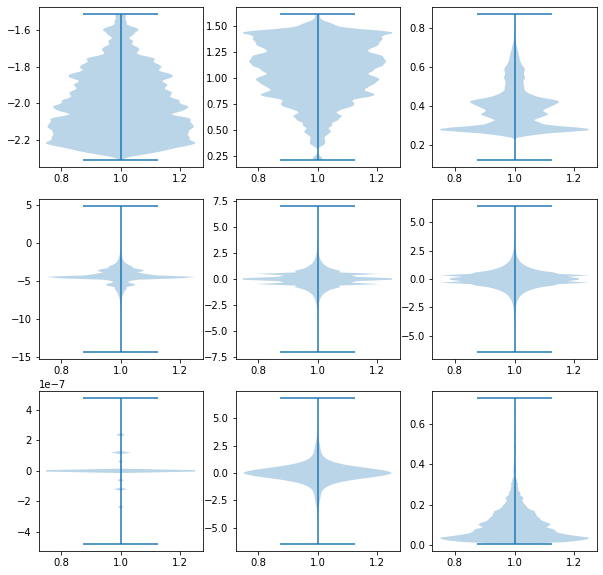

In [ ]:
fig, axs = plt.subplots(3,3,figsize=(10,10))
axs = axs.ravel()
for i,tmp2 in enumerate(recon_ers):
    ax=axs[i]
    ax.violinplot(tmp2.data)
plt.show()

In [ ]:
total_sum=[]
for ad in ads:
    smtx1=ad.X.copy()
    smtx1.data=np.exp(smtx1.data)-1
    total_sum.append(pd.DataFrame(smtx1.sum(axis=1)))

In [ ]:
tmp2.data

array([0.1274867 , 0.5245261 , 0.10737801, ..., 1.099268  , 3.3078172 ,
       0.00831318], dtype=float32)

In [ ]:
total_sum[-1][0]

0      9625.615234
1      9660.217773
2      9425.657227
3      9715.614258
4      9584.763672
          ...     
995    9084.113281
996    8629.284180
997    9005.947266
998    8449.074219
999    8799.000977
Name: 0, Length: 1000, dtype: float32

[<matplotlib.lines.Line2D>]

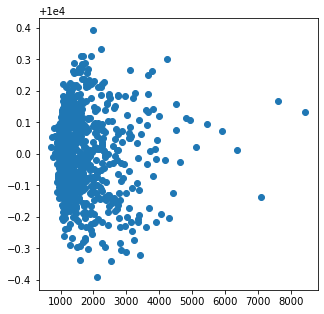

In [ ]:
tmp2=recon_ers[-2].copy()
tmp2.data=np.abs(tmp2.data)
plt.plot(tmp2.sum(axis=1),total_sum[-2][0],'o')

In [ ]:
scdenorm(ads[-6][:10],cutoff=0.1).X.data

/home/huang_yin/github/sc/scDenorm/scDenorm/denorm.py:94: RuntimeWarning: overflow encountered in power
  scaled_counts.data = base ** scaled_counts.data - cont
100%|██████████| 10/10 [00:00<00:00, 1541.12it/s]


array([11.,  1.,  1., ...,  1.,  1.,  4.], dtype=float32)

In [ ]:
ad=ads[-6]

In [ ]:
ad

AnnData object with n_obs × n_vars = 12672 × 33075
    obs: 'samplename', 'batch'

In [ ]:
ad.X.data

array([2.0004885, 2.0004885, 2.0004885, ..., 1.0001221, 1.0001221,
       1.0001221], dtype=float32)

In [ ]:
scdenorm(ad[:10],cutoff=0.1).X.data

100%|██████████| 10/10 [00:00<00:00, 1493.17it/s]


array([1., 2., 2., ..., 1., 1., 2.], dtype=float32)

In [ ]:
smtx2=ad.X.copy()

In [ ]:
smtx1=smtx2.copy()
smtx1.data=np.exp(smtx1.data)-1

/tmp/ipykernel_25800/2040155686.py:2: RuntimeWarning: overflow encountered in exp
  smtx1.data=np.exp(smtx1.data)-1


In [ ]:
smtx1.sum(axis=1)

matrix([[1.14947017e+32],
        [1.63061643e+19],
        [5.93625008e+18],
        [1.38647922e+16],
        [1.64753549e+09],
        [           inf],
        [           inf],
        [3.22740941e+10],
        [4.43771991e+12],
        [8.63203226e+24],
        [5.58466159e+37],
        [           inf],
        [           inf],
        [1.28261462e+03],
        [3.48311127e+02],
        [1.78013774e+26],
        [7.77414984e+10],
        [6.60934099e+11],
        [1.27433016e+31],
        [6.72430280e+14],
        [2.11555054e+02],
        [           inf],
        [2.61016817e+36],
        [           inf],
        [8.48486125e+24],
        [5.36402080e+08],
        [5.93440675e+18],
        [           inf],
        [3.38480375e+13],
        [2.12262672e+08],
        [7.43061295e+01],
        [2.60718506e+02],
        [2.17837225e+15],
        [1.87598080e+08],
        [1.08481767e+12],
        [           inf],
        [1.11980319e+24],
        [5.38696875e+03],
        [   

In [ ]:
ad.X.data

array([2.0004885, 2.0004885, 2.0004885, ..., 2.0004885, 1.0001221,
       1.0001221], dtype=float32)

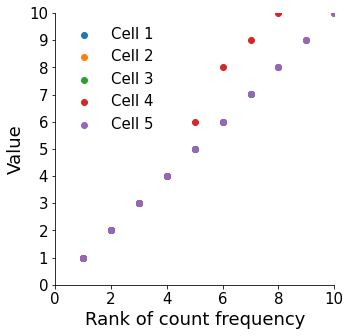

In [ ]:
figsize(5,5)
RCplot1(smtx2[:5],xm=10,ym=10)

{'whiskers': [<matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>],
 'caps': [<matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>],
 'boxes': [<matplotlib.lines.Line2D>],
 'medians': [<matplotlib.lines.Line2D>],
 'fliers': [<matplotlib.lines.Line2D>],
 'means': []}

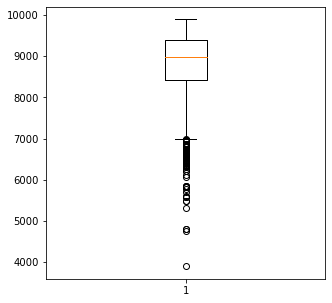

In [ ]:
plt.boxplot(smtx1.sum(axis=1))

[<matplotlib.lines.Line2D>]

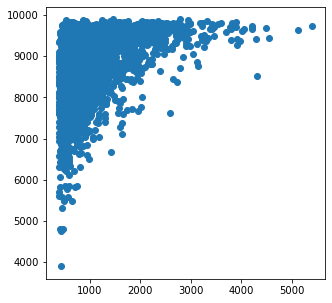

In [ ]:
plt.plot((smtx1>0).sum(axis=1),smtx1.sum(axis=1),'o')

In [ ]:
ad2=scdenorm(ad,verbose=1,cutoff=0.1,rint=False)
ad2.X.sort_indices()

INFO:root:The dimensions of this data are (3101, 16484).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 3101/3101 [00:01<00:00, 1768.91it/s]


In [ ]:
ad3=ad1.copy()
sc.pp.normalize_total(ad3, target_sum=1e4)
sc.pp.log1p(ad3)

In [ ]:
ad.X.data

array([0.44019213, 0.74479574, 0.74479574, ..., 2.292211  , 2.933516  ,
       2.292211  ], dtype=float32)

In [ ]:
ad3.X.data

array([0.453947 , 0.7650162, 0.7650162, ..., 2.9801917, 3.6476192,
       2.9801917], dtype=float32)

In [ ]:
print(ad3.X)

  (0, 48)	5.430541
  (0, 70)	5.430541
  (0, 82)	5.430541
  (0, 562)	5.430541
  (0, 593)	5.430541
  (0, 659)	5.430541
  (0, 675)	5.430541
  (0, 856)	5.430541
  (0, 860)	5.430541
  (0, 873)	5.430541
  (0, 988)	5.430541
  (0, 990)	5.430541
  (0, 1018)	5.430541
  (0, 1063)	5.430541
  (0, 1092)	5.430541
  (0, 1202)	5.430541
  (0, 1270)	5.430541
  (0, 1286)	5.430541
  (0, 1385)	5.430541
  (0, 1516)	5.430541
  (0, 1569)	5.430541
  (0, 1585)	5.430541
  (0, 1665)	5.430541
  (0, 1717)	5.430541
  (0, 1740)	5.430541
  :	:
  (9922, 28217)	2.4317544
  (9922, 28220)	3.9682925
  (9922, 28223)	2.4317544
  (9922, 28232)	3.469992
  (9922, 28236)	3.469992
  (9922, 28241)	2.4317544
  (9922, 28250)	2.4317544
  (9922, 28262)	3.749864
  (9922, 28263)	2.4317544
  (9922, 28267)	3.0799656
  (9922, 28307)	2.4317544
  (9922, 28312)	4.4311814
  (9922, 28331)	2.4317544
  (9922, 28332)	3.749864
  (9922, 28333)	4.651942
  (9922, 28334)	4.2993484
  (9922, 28335)	4.2993484
  (9922, 28337)	4.2993484
  (9922, 28338)	4.651

In [ ]:
print(ad.X)

  (0, 48)	5.43
  (0, 70)	5.43
  (0, 82)	5.43
  (0, 562)	5.43
  (0, 593)	5.43
  (0, 659)	5.43
  (0, 675)	5.43
  (0, 856)	5.43
  (0, 860)	5.43
  (0, 873)	5.43
  (0, 988)	5.43
  (0, 990)	5.43
  (0, 1018)	5.43
  (0, 1063)	5.43
  (0, 1092)	5.43
  (0, 1202)	5.43
  (0, 1270)	5.43
  (0, 1286)	5.43
  (0, 1385)	5.43
  (0, 1516)	5.43
  (0, 1569)	5.43
  (0, 1585)	5.43
  (0, 1665)	5.43
  (0, 1717)	5.43
  (0, 1740)	5.43
  :	:
  (9922, 28217)	2.43
  (9922, 28220)	3.97
  (9922, 28223)	2.43
  (9922, 28232)	3.47
  (9922, 28236)	3.47
  (9922, 28241)	2.43
  (9922, 28250)	2.43
  (9922, 28262)	3.75
  (9922, 28263)	2.43
  (9922, 28267)	3.08
  (9922, 28307)	2.43
  (9922, 28312)	4.43
  (9922, 28331)	2.43
  (9922, 28332)	3.75
  (9922, 28333)	4.65
  (9922, 28334)	4.3
  (9922, 28335)	4.3
  (9922, 28337)	4.3
  (9922, 28338)	4.65
  (9922, 28339)	4.43
  (9922, 28340)	3.08
  (9922, 28341)	5.06
  (9922, 28342)	2.43
  (9922, 28344)	3.97
  (9922, 28357)	2.43


In [ ]:
ad1.X.data

array([1., 2., 2., ..., 1., 2., 1.], dtype=float32)

In [ ]:
ad2.X.data

array([1.0000002, 2.0000005, 2.0000005, ..., 1.       , 2.0000002,
       1.       ], dtype=float32)

In [ ]:
tmp1=ad.X.todense()

In [ ]:
tmp1

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
tmp=ad3.X.todense()

In [ ]:
tmp2=abs(tmp-tmp1)

In [ ]:
tmp2.max()

0.015311718

In [ ]:
tmp2=ad3.X.copy()

In [ ]:
tmp2.data=np.abs(tmp2.data-ad.X.data)

In [ ]:
tmp2.sum(axis=1)/(tmp2>0).sum(axis=1)

matrix([[0.02033463],
        [0.02119847],
        [0.03676951],
        ...,
        [0.50868029],
        [0.4368006 ],
        [0.6928372 ]])

[<matplotlib.lines.Line2D>]

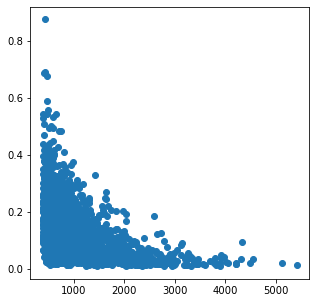

In [ ]:
plt.plot((tmp2>0).sum(axis=1),tmp2.sum(axis=1)/(tmp2>0).sum(axis=1),'o')

{'whiskers': [<matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>],
 'caps': [<matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>],
 'boxes': [<matplotlib.lines.Line2D>],
 'medians': [<matplotlib.lines.Line2D>],
 'fliers': [<matplotlib.lines.Line2D>],
 'means': []}

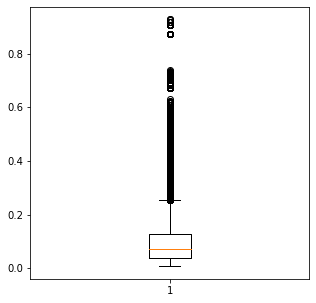

In [ ]:
plt.boxplot(tmp2.data)

{'whiskers': [<matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>],
 'caps': [<matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>],
 'boxes': [<matplotlib.lines.Line2D>],
 'medians': [<matplotlib.lines.Line2D>],
 'fliers': [<matplotlib.lines.Line2D>],
 'means': []}

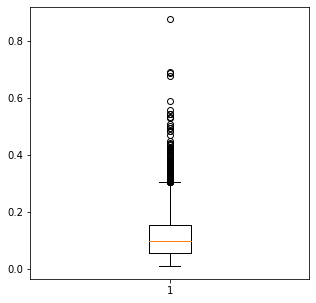

In [ ]:
plt.boxplot(tmp2.sum(axis=1)/(tmp2>0).sum(axis=1))

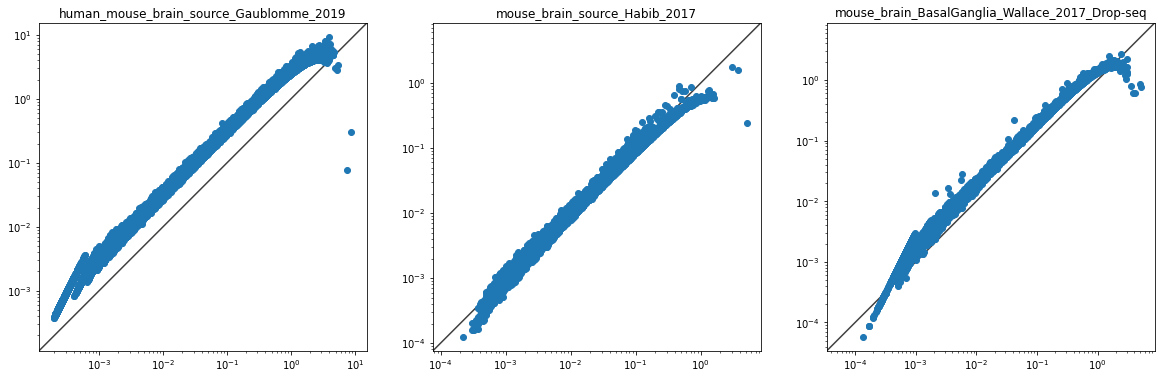

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(20,7))
axs = axs.ravel()
for i,h5 in enumerate(h5_paths_norm):
    ad=sc.read(h5)
    smtx=ad.X
    cmean = np.array(smtx.mean(0))
    cvar = np.array(smtx.power(2).mean(0) - cmean ** 2)

    ax=axs[i]
    ax.loglog()
    ax.scatter(cmean, cvar)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.title.set_text(h5.split('/')[-3])
#plt.savefig('figures/Sup_figure_5.pdf',dpi=600,format='pdf', transparent=True)
plt.show()

INFO:root:The dimensions of this data are (9923, 28363).
INFO:root:select base
INFO:root:denormlizing ...
100%|██████████| 9923/9923 [00:03<00:00, 2993.17it/s]
INFO:root:The dimensions of this data are (13313, 17308).
INFO:root:select base
INFO:root:denormlizing ...
100%|██████████| 13313/13313 [00:04<00:00, 3077.21it/s]
INFO:root:The dimensions of this data are (3101, 16484).
INFO:root:select base
INFO:root:denormlizing ...
100%|██████████| 3101/3101 [00:01<00:00, 3019.18it/s]


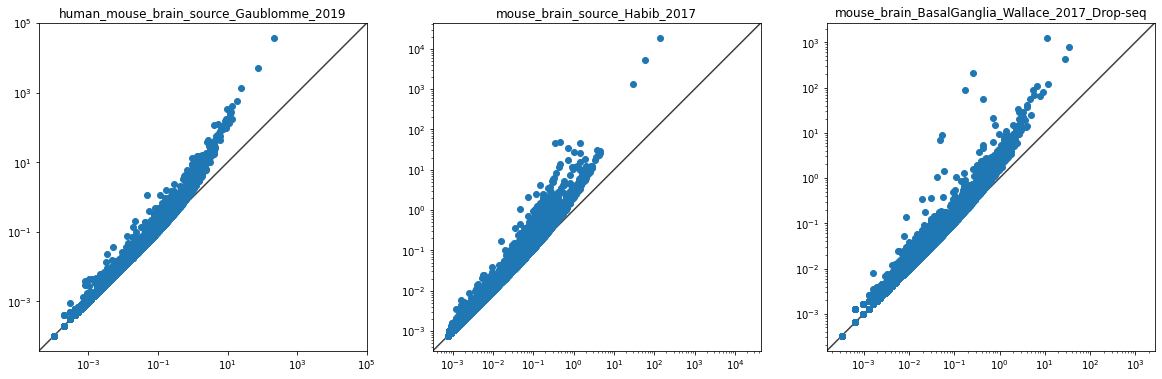

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(20,7))
axs = axs.ravel()
for i,h5 in enumerate(h5_paths_norm):
    ad=sc.read(h5)
    ad=scdenorm(ad,verbose=1)
    smtx=ad.X
    cmean = np.array(smtx.mean(0))
    cvar = np.array(smtx.power(2).mean(0) - cmean ** 2)

    ax=axs[i]
    ax.loglog()
    ax.scatter(cmean, cvar)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.title.set_text(h5.split('/')[-3])
plt.savefig('figures/Sup_figure_6.pdf',dpi=600,format='pdf', transparent=True)
plt.show()

In [ ]:
smtx2=ad.X.copy()

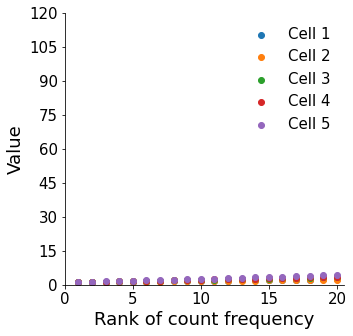

In [ ]:
tmp=smtx2[:5].copy()
tmp.data=np.exp(tmp.data)
RCplot1(tmp,xm=20.5,ym=120)

##### auto 1

In [ ]:
np.random.seed(0)
num=100
ress=[]
for _ in range(num):
    ys=[]
    for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],100),replace=False):
        try:
            c = pd.Series(smtx2.getrow(c_idx).data)
            y = np.array(c.value_counts().sort_index().head(2).index)
            ys.append(y)
        except:
            print(c_idx)
    ys=np.array(ys)
    y1=ys[:,0]
    y2=ys[:,1]
    res = minimize(solve_bc, [20,1], method='L-BFGS-B', tol=1e-10,bounds=[(1.9, None), (1e-6, None)],args=(ys[:,0],ys[:,1]))
    ress.append([res.x[0],res.x[1],res.fun])

In [ ]:
res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1.2685859667034169e-11
        x: [ 2.718e+00  1.000e+00]
      nit: 24
      jac: [-2.397e-07 -2.164e-09]
     nfev: 75
     njev: 25
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [ ]:
np.random.seed(0)
ys=[]
for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],1000),replace=False):
    try:
        c = pd.Series(smtx2.getrow(c_idx).data)
        y = np.array(c.value_counts().sort_index().head(2).index)
        ys.append(y)
    except:
        print(c_idx)
ys=np.array(ys)
y1=ys[:,0]
y2=ys[:,1]
res = minimize(solve_bc, [20,1], method='L-BFGS-B', tol=1e-10,bounds=[(1.9, None), (1e-6, None)],args=(ys[:,0],ys[:,1]))
res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 283.8199405639
        x: [ 2.720e+00  9.501e-01]
      nit: 58
      jac: [-3.865e-04  1.137e-05]
     nfev: 177
     njev: 59
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [ ]:
ress=pd.DataFrame(ress,columns=['base','pseudo','loss'])

In [ ]:
ress.base.mean()

2.7191298970262134

In [ ]:
ress.pseudo.mean()

0.9768548143312201

In [ ]:
ress.loss.mean()

29.036462952252446

In [ ]:
ress

,base,pseudo,loss
0,2.720345,0.935864,24.736166
1,2.712499,1.105944,33.639006
2,2.717954,1.017385,38.550197
3,2.722551,0.947615,20.563327
4,2.720817,0.951716,16.043114
...,...,...,...
95,2.722736,0.915169,26.770776
96,2.722104,0.922724,16.744037
97,2.715752,1.055545,18.837839
98,2.721432,0.936030,35.057240


{'whiskers': [<matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>],
 'caps': [<matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>],
 'boxes': [<matplotlib.lines.Line2D>],
 'medians': [<matplotlib.lines.Line2D>],
 'fliers': [<matplotlib.lines.Line2D>],
 'means': []}

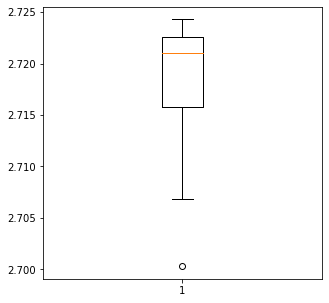

In [ ]:
plt.boxplot(ress.base)

/home/huang_yin/anaconda3/envs/sc06/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='base'>

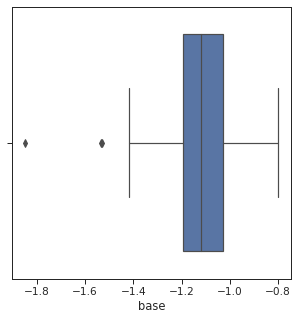

In [ ]:
sns.boxplot((ress.base-2)*10**8)

/home/huang_yin/anaconda3/envs/sc06/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pseudo'>

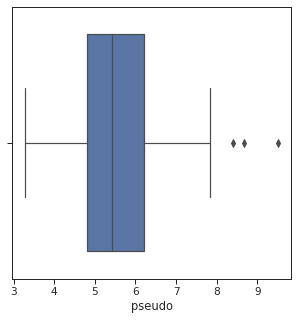

In [ ]:
sns.boxplot((ress.pseudo-1)*10**8)

/home/huang_yin/anaconda3/envs/sc06/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='loss'>

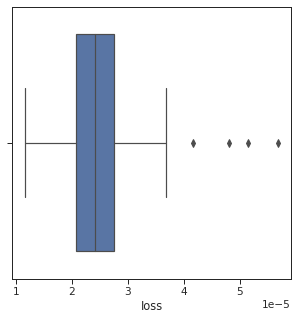

In [ ]:
sns.boxplot((ress.loss)*10**8)

### Fitted curve

In [ ]:
np.random.seed(0)
ys=[]
for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],100),replace=False):
    try:
        c = pd.Series(smtx2.getrow(c_idx).data)
        y = np.array(c.value_counts().sort_index().head(2).index)
        ys.append(y)
    except:
        print(c_idx)
ys=np.array(ys)
y1=ys[:,0]
y2=ys[:,1]
res = minimize(solve_bc, [20,1], method='L-BFGS-B', tol=1e-10,bounds=[(1.9, None), (1e-6, None)],args=(ys[:,0],ys[:,1]))

In [ ]:
"#4C72B0" (blue)
"#DD8452" (orange)
"#55A868" (green)
"#C44E52" (red)
"#8172B2" (purple)
"#937860" (brown)
"#DA8BC3" (pink)
"#8C8C8C" (gray)
"#CCB974" (yellow)
"#64B5CD" (turquoise)

In [ ]:
res

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 3.1748333239079074e-13
        x: [ 2.000e+00  1.000e+00]
      nit: 50
      jac: [ 2.605e-11 -7.546e-12]
     nfev: 153
     njev: 51
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [ ]:
def solve_bc(p,y1,y2):
    return sum((np.exp(y2*np.log(p[0]))-2*np.exp(y1*np.log(p[0]))+p[1])**2)

In [ ]:
def predbybc(y1,base,cont):
    return np.log(2*np.exp(y1*np.log(base))-cont)/np.log(base)

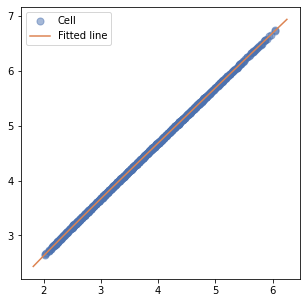

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# generate some sample data
x = y1
y = y2

# fit a line to the data
x_new=np.linspace(min(x)-0.2,max(x)+0.2,num=100)
fitted_y = predbybc(x_new,res.x[0],res.x[1])

# plot the data and the fitted line
plt.scatter(x, y, s=50, c='#4C72B0', alpha=0.5,label='Cell')
plt.plot(x_new, fitted_y, c='#DD8452', label='Fitted line')
plt.legend()
plt.show()

In [ ]:
def plot_fitted(x,y,save=None):
    x_new=np.linspace(min(x),max(x),num=100)
    fitted_y = predbybc(x_new,res.x[0],res.x[1])

    fig, ax = plt.subplots()
    ax.scatter(x, y, s=50, c='#4C72B0', alpha=0.5,label='Cell')
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    ax.plot(x_new, fitted_y, linewidth=2, alpha=0.75, color='red', label='Fitted line')
    ax.set_aspect('equal')
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel('First rank',fontsize=18)
    ax.set_ylabel('Second rank',fontsize=18)
    ax.legend(loc='lower right', frameon=False, fontsize=16)
    
    if save:
        plt.savefig(save,dpi=300, bbox_inches='tight',transparent=True)

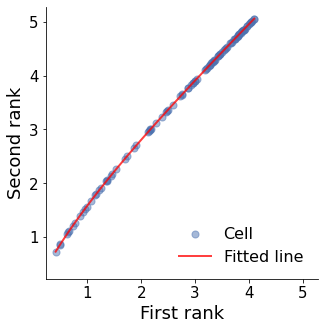

In [ ]:
plot_fitted(x,y,save='figures/realdata/auto_bc_fitted.pdf')

In [ ]:
ress

,base,pseudo,loss
0,2.0,1.0,3.174833e-13
1,2.0,1.0,1.914418e-13
2,2.0,1.0,2.073553e-13
3,2.0,1.0,2.411723e-13
4,2.0,1.0,2.775597e-13
...,...,...,...
95,2.0,1.0,2.630410e-13
96,2.0,1.0,2.259916e-13
97,2.0,1.0,2.724132e-13
98,2.0,1.0,2.280083e-13


[<matplotlib.lines.Line2D>]

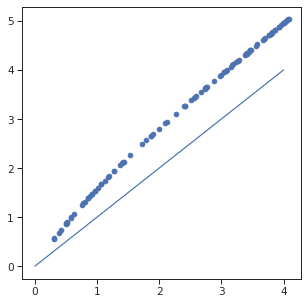

In [ ]:
plt.scatter(y1,y2)


In [ ]:
ys=[]
for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],1000),replace=False):
    try:
        c = pd.Series(smtx2.getrow(c_idx).data)
        y = np.array(c.value_counts().sort_index().head(2).index)
        ys.append(y)
    except:
        print(c_idx)
ys=np.array(ys)
y1=ys[:,0]
y2=ys[:,1]

(array([  8.,  19.,  43.,  40.,  36.,  79.,  64.,  48.,  99., 564.]),
 array([0.1821543 , 0.25982992, 0.33750555, 0.41518117, 0.49285679,
        0.57053242, 0.64820804, 0.72588367, 0.80355929, 0.88123491,
        0.95891054]),
 <BarContainer object of 10 artists>)

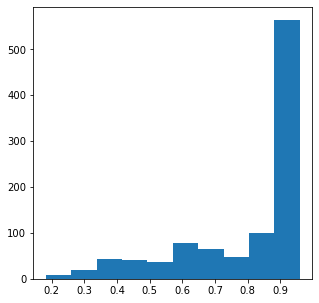

In [ ]:
figsize(5,5)
plt.hist(y2-y1)

<matplotlib.collections.PathCollection>

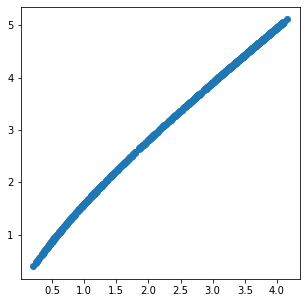

In [ ]:
plt.scatter(y1,y2)

<matplotlib.collections.PathCollection>

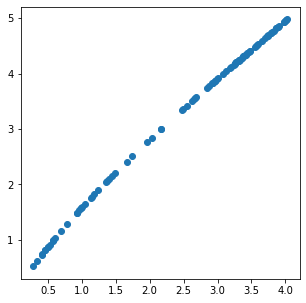

In [ ]:
plt.scatter(y1[:100],y2[:100])

##### auto 2

In [ ]:
def f1(p, x, y):
    u = np.log(p[0]*x+p[2])/np.log(p[1])
    return np.sum((u-y)**2)

def grad_f1(p, x, y):
    u = np.log(p[0]*x+p[2])/np.log(p[1])
    dudx = p[0]/((p[0]*x+p[2])*np.log(p[1]))
    dudp = 1/np.log(p[1])
    grad_u = np.vstack((dudx, np.zeros_like(p[1:]), dudp))
    return 2*np.sum(grad_u*(u-y), axis=1)
bounds = [(1e-6, None), (1.9, None), (1e-6, None)]
#res = minimize(f1, [1, 2.7, 0.1], method='L-BFGS-B', tol=1e-6, bounds=bounds, args=(x, y))

In [ ]:
ress=[]
for c_idx in range(1000):
    N=10
    try:
        c = pd.Series(smtx2.getrow(c_idx).data)
        y = np.array(c.value_counts().sort_index().head(N).index)
        x = np.arange(1, N+1)
        res = minimize(f1, [10,20,1], method='L-BFGS-B', tol=1e-10, bounds=bounds, args=(x, y))
        ress.append([res.x[0],res.x[1],res.x[2],res.fun,N,int(res.fun<10**-5)])
    except:
        print(c_idx)
ress=pd.DataFrame(ress,columns=['s','b','c','l','n','p'])

0
15
21
23
27
31
39
47
49
51
58
68
70
75
76
88
95
96
107
109
118
121
125
128
135
136
138
139
145
147
150
165
172
176
179
180
181
188
199
202
211
213
216
220
226
232
236
237
238
241
245
247
250
260
262
270
272
275
276
283
284
285
290
293
301
314
318
323
326
335
336
338
342
344
349
357
365
371
385
391
396
398
401
405
415
418
424
425
428
448
456
460
468
478
479
481
483
493
508
513
519
526
549
554
556
565
566
567
573
580
584
586
587
591
602
606
611
613
624
625
634
638
640
641
646
649
650
655
663
671
673
682
683
693
700
704
712
719
726
730
731
732
733
734
738
742
744
760
770
773
777
783
795
796
799
800
810
813
815
816
817
819
825
828
835
840
844
849
851
860
866
869
870
881
888
889
893
894
900
901
902
906
915
917
923
925
927
929
933
942
948
955
964
970
973
989
991
995


In [ ]:
ress

,s,b,c,l,n,p
0,10.084992,2.724389,0.884692,0.000017,10,0
1,7.880922,2.742358,0.875675,0.000044,10,0
2,19.258143,2.718225,1.035563,0.000073,10,0
3,21.994972,2.211144,12.911348,0.034169,10,0
4,10.275391,2.698106,1.108882,0.000044,10,0
...,...,...,...,...,...,...
797,37.072946,2.707084,1.199263,0.000041,10,0
798,33.578246,2.723052,0.747813,0.000054,10,0
799,10.276960,2.043078,9.385810,0.058174,10,0
800,8.455677,1.900000,9.165396,0.306397,10,0


In [ ]:
ress[ress.p==1]

,s,b,c,l,n,p


In [ ]:
ress=[]
for N in range(3,16):
    for c_idx in range(1000):
        try:
            c = pd.Series(smtx2.getrow(c_idx).data)
            y = np.array(c.value_counts().sort_index().head(N).index)
            x = np.arange(1, N+1)
            res = minimize(f1, [10,20,1], method='L-BFGS-B', tol=1e-10, bounds=bounds, args=(x, y))
            ress.append([res.x[0],res.x[1],res.x[2],res.fun,N,int(res.fun<10**-5)])
        except:
            pass
            #print(c_idx)
ress=pd.DataFrame(ress,columns=['s','b','c','l','n','p'])

In [ ]:
ress.n.value_counts()

3     999
4     999
5     999
6     998
7     983
8     937
9     856
10    753
11    660
12    598
13    547
14    499
15    468
Name: n, dtype: int64

<AxesSubplot:xlabel='n', ylabel='l'>

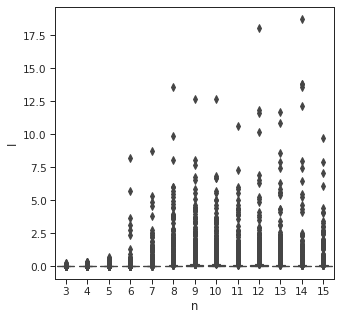

In [ ]:
sns.boxplot(data=ress,x='n',y='l')

<AxesSubplot:xlabel='n', ylabel='l'>

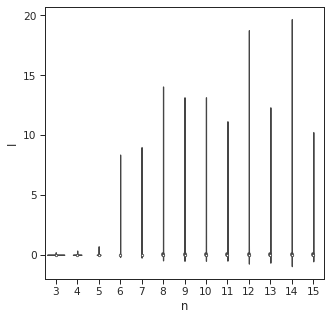

In [ ]:
sns.violinplot(data=ress,x='n',y='l')

<AxesSubplot:xlabel='n', ylabel='l'>

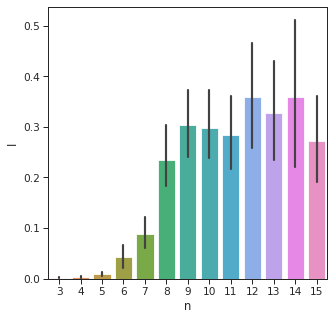

In [ ]:
sns.barplot(data=ress,x='n',y='l')

<AxesSubplot:xlabel='n', ylabel='b'>

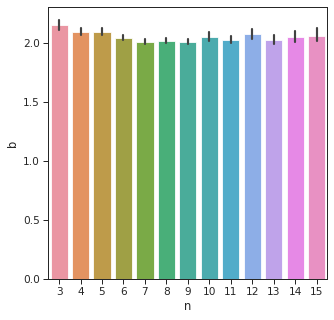

In [ ]:
sns.barplot(data=ress,x='n',y='b')